![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

<div class="alert alert-warning">
This notebook still needs to go through revision.
</div>

# DMD analysis of airfoil surface data

In this notebook, we perform DMD on a more challenging example. We are presented with surface data from an *OpenFOAM* IDDES simulation of a NACA-0012 airfoil in transonic flow conditions. In the simulation, a *pressure* function object computes the total pressure coefficient on the airfoil's surface, and a *surfaces* function object samples the surface and outputs the data as raw text files. The Reynolds number based on the chord length $c$, the freestream velocity $U_\infty$, and the kinematic viscosity $\nu$ is $Re=U_\infty c / \nu = 10^7$. The freestream Mach number is $Ma=0.75$. At $\alpha = 4^\circ$ angle of attack, the airfoil experiences the so-called transonic shock buffet, which we analyze in this notebook. The simulation setup is available in [this repository](https://github.com/AndreWeiner/naca0012_shock_buffet).

In [1]:
from glob import glob
import torch as pt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from flowtorch.analysis.svd import SVD
from flowtorch.analysis.dmd import DMD

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160

## Assembling the data matrix

The data consist of raw text files organized in time folders. The text files have four columns, three for each coordinate of the sample locations and one for the pressure coefficient. The *pandas.read_csv* function is an excellent tool to load and process any kind of raw *OpenFOAM* output. Below, we define a short function wrapping around the CSV reader to facilitate fetching the surface data.

In [2]:
def fetch_surface_data(path):
    """Load and process surface sample data.
    
    Note: trailing edge data is removed for x>=0.999c.

    Parameters
    ----------
    path - str: path to csv file

    Returns
    -------
    x - array: normalized position vector of sample points;
        shape (n_points, 3)
    f - array: surface field values in sample points;
        shape (npoints,)

    """
    data = pd.read_csv(path, sep=" ", skiprows=[
                       0, 1], header=None, names=["x", "y", "z", "f"])
    # x_max is the chord length
    x = data[data.x < 0.999][["x", "y", "z"]].values / data.x.max()
    return x, data[data.x < 0.999].f.values

Now we create a list of all available time folders and discard the intial snapshots $t\le 0.07$. To select a suitable time window for the analysis, one option is to examine the temporal evolution of lift and drag, but you can also eyeball the beginning of the quasi-steady state in *ParaView*. We use *glob* to extract the folder names and sort the snapshot times. **Be careful when sorting times represented as String objects.** The sorting might look largly correct, but often times a few values are placed incorrectly. For example, sorting the list `["0.3", "0", "0.2"]` results in `["0", "0.2", "0.3"]`, but sorting the list `["0", "0.1", "1e-5"]` returns a list with the same order. Therefore, explicitly use the `float` function as key for sorting.

In [3]:
data_path = "../../../test/test_data/external_data/naca0012_buffet_surface/"
times = glob(data_path + "*")
times = [time.split("/")[-1] for time in times]
times = sorted(times, key=float)
times = [time for time in times if float(time) > 0.07]

print(f"Found {len(times)} snapshots.")
print(times[:5])

Found 133 snapshots.
['0.071', '0.072', '0.073', '0.074', '0.075']


Next, we fetch the first snapshot to inspect the number of sample points, and to test visualizing the surface data. The function `add_surface_to_axes` splits the surface data into lower and upper side of the airfoil and creates one contour plot for each side.

In [4]:
file_name = "total(p)_coeff_airfoil.raw"
pos, cp = fetch_surface_data(data_path + times[0] + "/" + file_name)
print(pos.shape, cp.shape)

(28892, 3) (28892,)


In [5]:
def add_surface_to_axes(ax_up, ax_low, pos, field):
    """Add contour plots to axes.
    
    The function splits the field into lower and upper side data
    according to the supplied position vector, and add one contour
    plot to each axis.
    
    Parameters
    ----------
    ax_* - Axis: axis objects to which the contour plots are added
    pos - array: position vector in Cartesian coordintes
    field - array: field to plot
    
    """
    pos_up = pos[pos[:, 1] > 0]
    pos_low = pos[pos[:, 1] <= 0]
    f_up = field[pos[:, 1] > 0]
    f_low = field[pos[:, 1] <= 0]
    f_min = f_up.min()
    f_max = f_up.max()
    tri = ax_up.tricontourf(pos_up[:, 0], pos_up[:, 2], f_up, levels=15, cmap="jet", vmin=f_min, vmax=f_max)
    ax_low.tricontourf(pos_low[:, 0], pos_low[:, 2], f_low, levels=15, cmap="jet", vmin=f_min, vmax=f_max)
    ax_up.set_aspect("equal", 'box')
    ax_low.set_aspect("equal", 'box')
    # adding the colorbar makes the left plot slightly smaller; needs to be fixed
    # cbar = plt.colorbar(tri, ax=ax_low, ticks=[0.8*f_min, 0.5*(f_max+f_min), 0.8*f_max], aspect=10, shrink=0.5)
    # cbar.ax.tick_params(labelsize=8)

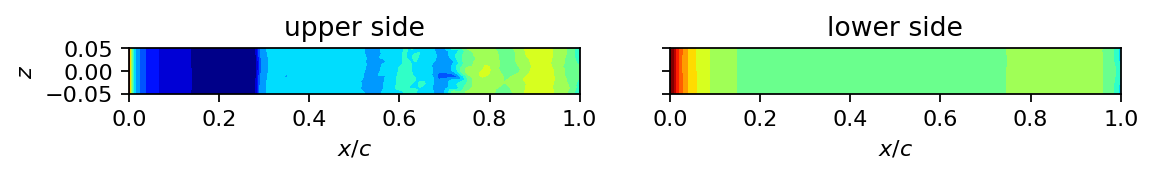

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,1), sharex=True, sharey=True)
cb = add_surface_to_axes(ax1, ax2, pos, cp)
for ax in (ax1, ax2):
    ax.set_xlabel(r"$x/c$")
ax1.set_ylabel(r"$z$")
ax1.set_title("upper side")
ax2.set_title("lower side")
plt.show()

Now we assemble the data matrix. The function *fetch_surface_data* returns *numpy* arrays, which can be conveniently converted into *PyTorch* tensors using `from_numpy`. Once the snapshots are loaded into the data matrix, it is always a good idea to look at the temporal mean and standard deviation to see if there are oddities in the data. For example, look for extreme values and check if symmetries you expect are (at least roughly) fulfilled. In the present data, we see that the flow is mostly symmetric in the $z$-direction. The strongest fluctuations occur on the upper side around the shock and where the boundary layer separates.

In [7]:
data_matrix = pt.zeros((cp.shape[0], len(times)), dtype=pt.float32)
for i, time in enumerate(times):
    data_matrix[:, i] = pt.from_numpy(fetch_surface_data(data_path + time + "/" + file_name)[1]).type(pt.float32)

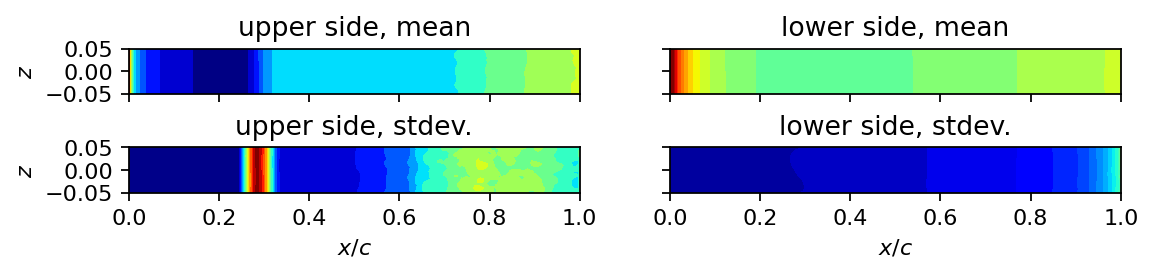

In [8]:
fig, axarr = plt.subplots(2, 2, figsize=(8, 1.5), sharex=True, sharey=True)

add_surface_to_axes(axarr[0, 0], axarr[0, 1], pos, pt.mean(data_matrix, dim=1))
add_surface_to_axes(axarr[1, 0], axarr[1, 1], pos, pt.std(data_matrix, dim=1))
axarr[0, 0].set_title("upper side, mean")
axarr[1, 0].set_title("upper side, stdev.")
axarr[0, 1].set_title("lower side, mean")
axarr[1, 1].set_title("lower side, stdev.")
axarr[1, 0].set_xlabel(r"$x/c$")
axarr[1, 1].set_xlabel(r"$x/c$")
axarr[0, 0].set_ylabel(r"$z$")
axarr[1, 0].set_ylabel(r"$z$")
plt.show()

## Singular value decomposition

Next, we examine the singular values. Snapshots of turbulent flows are not as easy to truncate as laminar flows with periodic vortex shedding. The singular values decrease only slowly, and therefore, we need a larger rank to cover a significant portion of the variance in the data. In the following analysis, we stick to the suggested [optimal rank for truncation](svd_ht.ipynb). Since the `svd` object contains also the left singular vectors, we can take a look at the POD modes and compare them later on to the DMD modes.

In [9]:
svd = SVD(data_matrix, rank=200)
print(svd)

SVD of a 28892x133 data matrix
Selected/optimal rank: 133/47
data type: torch.float32 (4b)
truncated SVD size: 14.7265Mb


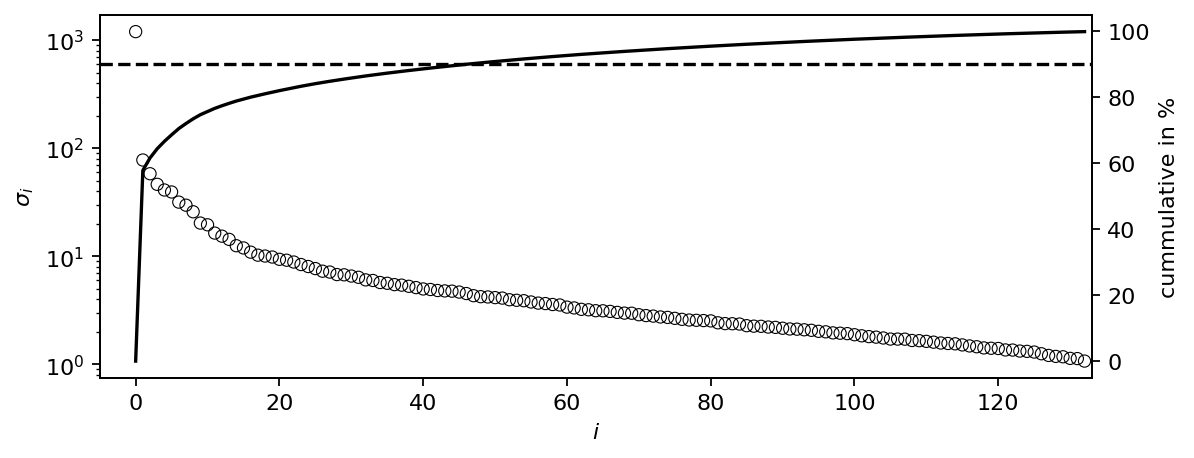

In [10]:
s_sum = [svd.s[:n].sum()/svd.s.sum()*100 for n in range(svd.s.shape[0])]

fig, ax = plt.subplots(figsize=(8, 3))
ax_sum = ax.twinx()
ax.scatter(range(svd.s.shape[0]), svd.s, s=30, facecolor="None", edgecolor="k", lw=0.5)
ax_sum.plot(range(svd.s.shape[0]), s_sum, c="k")
ax.set_yscale("log")
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$\sigma_i$")
ax.set_xlim(-5, svd.s.shape[0])
ax_sum.set_ylabel("cummulative in %")
ax_sum.axhline(90, ls="--", c="k")
plt.show()

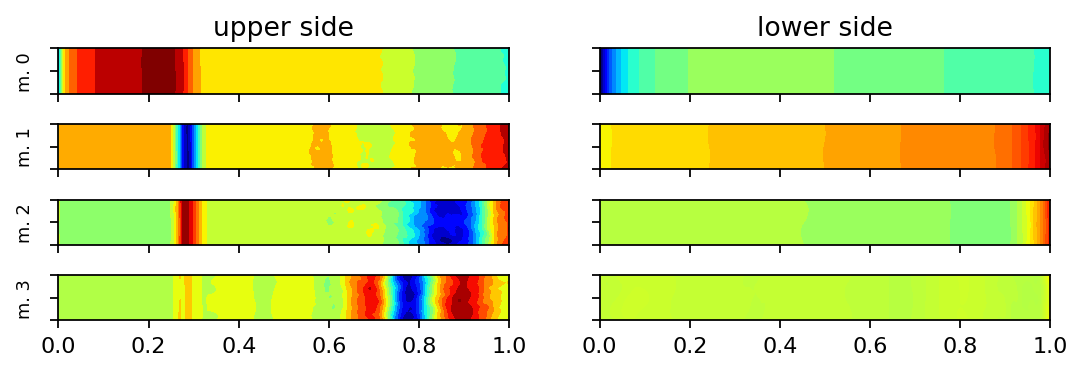

In [11]:
modes = (0, 1, 2, 3)
height = 0.6

fig, axarr = plt.subplots(len(modes), 2, figsize=(8, height*len(modes)), sharex=True, sharey=True)
for row in range(len(modes)):
    add_surface_to_axes(axarr[row, 0], axarr[row, 1], pos, svd.U[:, modes[row]])
    axarr[row, 0].set_ylabel(f"m. {modes[row]}", fontsize=8)
    axarr[row, 0].set_yticklabels([])
axarr[0, 0].set_title("upper side")
axarr[0, 1].set_title("lower side")
plt.show()

## Dynamic mode decomposition

What the DMD offers as in contrast to the SVD is direct information about frequencies and amplitudes of coherent structures in the data. If no `rank` value is supplied to the constructor, the rank is estimated automatically as explained [here](svd_ht.ipynb). The choosen rank is 47, which may be verified by executing `print(dmd)`.

In [12]:
dmd = DMD(data_matrix)

As usually, we first examine the eigen values. Idially, the eigen values should be placed on the unit circle, which is not the case in this example. There are several effects causing the result. The main problem is the SVD's inability to handle translating and rotating structures, as explained in the notebook [An introduction to the dynamic mode decomposition](dmd_intro.ipynb). The situation might be improved if we had more data. More data in the present analysis means that we should have sampled at a higher frequency and also over a longer time period. Unfortunately, the IDDES simulations are costly. Having a preliminary idea about the expected frequency spectrum and the integral time scale is extremely valuable.

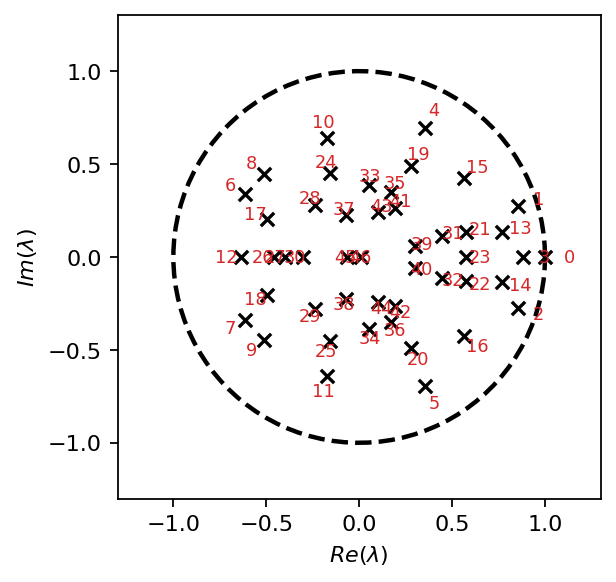

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))

t = pt.linspace(0, 2 * np.pi, 100)
ax.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
ax.scatter(dmd.eigvals.real, dmd.eigvals.imag, marker="x", color="k")
for j, val in enumerate(dmd.eigvals):
    ax.annotate(f"{j}", (val.real*1.13, val.imag*1.13), ha='center', va="center", fontsize=8, zorder=6, color="C3")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_xlabel(r"$Re(\lambda)$")
ax.set_aspect("equal")
ax.set_ylabel(r"$Im(\lambda)$")
plt.show()

The buffet frequency reported in [Static and Dynamic Pressure Measurements on a NACA 0012 Airfoil in the Ames High Reynolds Number Facility](https://ntrs.nasa.gov/citations/19850019511) by J. B. McDevitt and A. F. Okuno is about $31 Hz$ (set 1 flow conditions in the report). This frequency was obtained from pressure measurement at $50\%$ chord on the upper side of the airfoil. The spectrum visualized below contains vertical lines at the buffet frequency and multiples of buffet frequency. The markers are scaled by the DMD modes' magnitude. We see that there are several modes very close to the buffet frequency. In particular, mode 13 seems to be interesting since it has a large magnitude and is close to the buffet frequency.

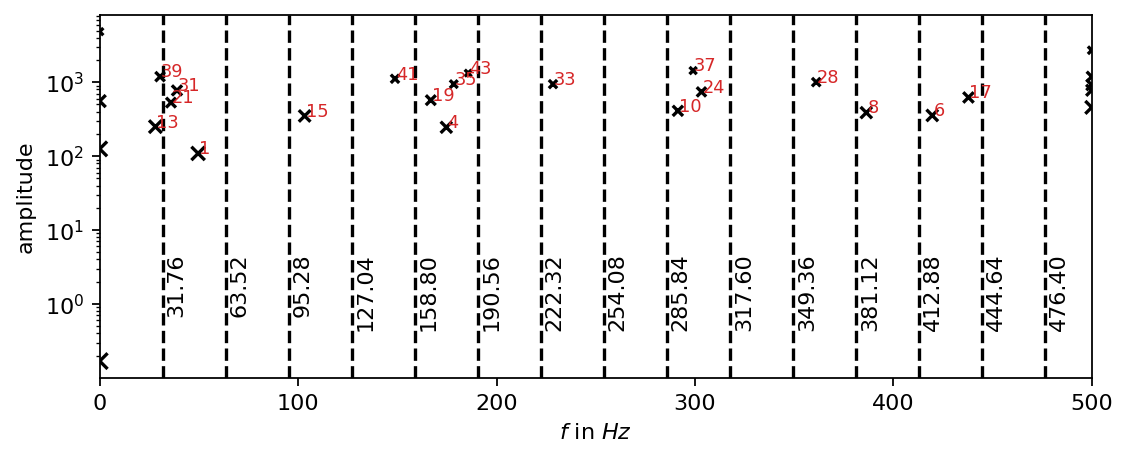

In [14]:
fig, ax= plt.subplots(figsize=(8, 3))
amplitude, frequency = dmd.spectrum(dt = 0.001)
mode_norm = pt.linalg.norm(dmd.modes.real, dim=0)
ax.scatter(frequency, amplitude.abs(), marker="x", c="k", s=mode_norm*50)
for j, (a, f) in enumerate(zip(amplitude, frequency)):
    if f > 0:
        ax.annotate(f"{j}", (f+0.5, a.abs()), fontsize=8, c="C3")
ax.set_xlabel(r"$f$ in $Hz$")
ax.set_xlim(0, 500)
ax.set_yscale("log")
ax.set_ylabel(r"amplitude")
f_ref = 31.76
for i in range(1, 16):
    ax.axvline(f_ref*i, ls="--", c="k")
    ax.text(f_ref*i+2, 5, r"{:2.2f}".format(f_ref*i), rotation=90, va="top")
plt.show()

In the final step, we visualize several of the DMD modes with frequencies close to the buffet frequency and the steady mode. A DMD mode shows us, which regions fluctuate jointly at the frequency associated the the mode. In the modes 13 and 1, we see a strong correlation between the shock and the separated boundary layer: the pressure coefficient increases where the boundary layer separates, while it drops around the shock. It is a common pattern that tanslatory structures are split up into several *shifted* modes in SVD-based algorithms. Modes 1 and 13 fall into that category. Examining mode 1, we see also a pronounced correlation of osciallations around the trailing edge, lower and upper side, with the shock oscillation. We now have initial proof that shock motion and boundary layer separation are strongly correlated. Because the region between the shock and the separated boundary layer does not oscillate at the same frequency, we may assume that the connection between the two flow patterns happens somewhere within the flow above the upper surface, which we can not analyze with the present dataset.

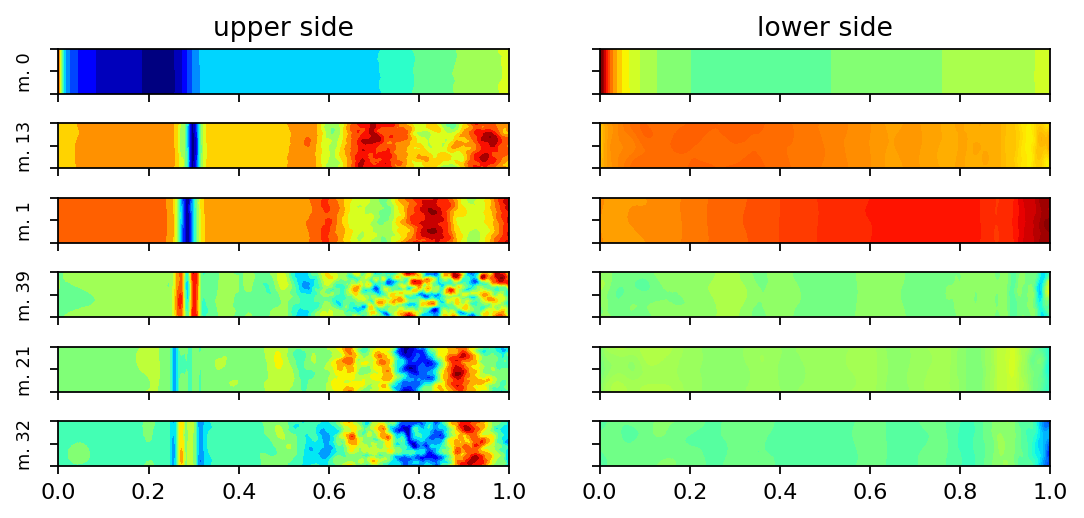

In [15]:
modes = (0, 13, 1, 39, 21, 32)
height = 0.6

fig, axarr = plt.subplots(len(modes), 2, figsize=(8, height*len(modes)), sharex=True, sharey=True)
count = 1
for row in range(len(modes)):
    add_surface_to_axes(axarr[row, 0], axarr[row, 1], pos, dmd.modes[:, modes[row]].real)
    axarr[row, 0].set_ylabel(f"m. {modes[row]}", fontsize=8)
    axarr[row, 0].set_yticklabels([])
axarr[0, 0].set_title("upper side")
axarr[0, 1].set_title("lower side")
plt.show()